# Guwahati Job Setup and Post-Processing

Mostly minor reformatting.

## Job Setup

In [11]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import ast
import glob
import codecs
import inspect
import warnings
import itertools
import datetime

import pyproj
import shapely

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

%autoreload 2
import toolbox as tb
%autoreload 2
import source_model_tools as smt
%autoreload 2
import gmpe_tools as gmt

from hmtk import sources as src
import hmtk

%autoreload 2
import oq_output.hazard_curve_converter as hcc
%autoreload 2
import oq_output.hazard_map_converter as hmc

from openquake.hazardlib import geo

In [13]:
nath_path = '../Data/nath2012probabilistic'
sites_table = os.path.join(nath_path, 'Table 3.csv')
df_table3 = pd.read_csv(sites_table, skiprows=1)
df_table3

,City,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
0,Ahmedabad,23.03,72.61,0.08,III,0.05,0.11,0.10,Jaiswal and Sinha 2007†
1,Bangalore,12.98,77.58,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
2,Bhuj,23.25,69.66,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
3,Chennai,13.00,80.18,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
4,Dehradun,30.33,78.04,0.12,IV,0.30,0.47,0.45,Mahajan et al. 2010
5,Guwahati,26.18,91.73,0.18,V,0.30,0.66,0.50,Sharma and Malik 2006
6,Hyderabad,17.45,78.46,0.05,II,0.05,0.09,0.08,Jaiswal and Sinha 2007†
7,Imphal,24.78,93.94,0.18,V,0.45,0.68,0.50,Sharma and Malik 2006
8,Jabalpur,23.20,79.95,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†
9,Kolkata,22.65,88.45,0.08,III,0.10,0.15,0.10,Jaiswal and Sinha 2007†


In [18]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_inv = 1./12  # year
poes_inv = 1 - np.exp(-rate*T_inv)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_inv))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_inv]))
print(poe_labels)

investigation_time = 0.0833333333333
poes = 0.00017559 3.3671e-05
['10% in 50 years', '2% in 50 years']


In [15]:
im_types = ['PGA', 'SA(0.2)', 'SA(1.0)']
periods = tb.logspace(0.005, 4, 3)
periods_string = ', '.join([str(T) for T in periods])

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (im_type, periods_string) 
                   for im_type in im_types]))

intensity_measure_types_and_levels = {"PGA": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(0.2)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], "SA(1.0)": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]}


In [16]:
def lonlat2xy(lon_ref_deg, lat_ref_deg, lon_deg, lat_deg, projection=None):
    
    # better to construct projection once externally, but if none given ...
    if projection is None:
        projection = pyproj.Geod(ellps='WGS84')
        
    azimuth_deg, _, distance_m = projection.inv(lon_ref_deg, lat_ref_deg, lon_deg, lat_deg, 
                                                radians=False)
    x_km = distance_m*np.sin(azimuth_deg*np.pi/180.)/1000.
    y_km = distance_m*np.cos(azimuth_deg*np.pi/180.)/1000.
    
    return (x_km, y_km)

In [19]:
city = 'Guwahati'
max_distance_km = 40 
city_series = df_table3[df_table3['City'] == city]
areal_source_model_file = r'../Source Models/areal_source_model'
areal_df = pd.read_csv(areal_source_model_file + '_no_twin.tsv', sep='\t')

geod = pyproj.Geod(ellps='WGS84')
origin = shapely.geometry.Point(0, 0)

nearest_zones = []
for _, area_series in areal_df.iterrows():
    coords_deg = np.array(ast.literal_eval(area_series['polygon coordinates']))
    coords_km = np.array([lonlat2xy(city_series['Longitude (°E)'].values, 
                                      city_series['Latitude (°N)'].values,
                                      lon, lat)
                 for lon, lat in coords_deg]).reshape((-1, 2))

    polygon = shapely.geometry.Polygon(coords_km)
    distance_km = np.sqrt(polygon.distance(origin)**2 + area_series['zmin']**2)
    if distance_km <= max_distance_km:
        nearest_zones.append(area_series['zoneid'])

nearest_indices = [zone_id in nearest_zones for zone_id in areal_df['zoneid'].values]

nearest_df = areal_df[nearest_indices]
display(nearest_df)
nearest_df = smt.add_name_id(nearest_df)
nearest_df = smt.sort_and_reindex(nearest_df)
nearest_df.to_csv(areal_source_model_file + '_guwahati.tsv', sep='\t', index=False)

,id,zoneid,layerid,tectonic subregion,mmin,a,areal lambda 4.5,areal lambda 5.5,aspect ratio,b,...,smoothed a 4.5,smoothed a 5.5,smoothed lambda 4.5,smoothed lambda 5.5,stdb,stdmmax,strike,tectonic zone,zmax,zmin
46,z119,119,2,intraplate margin lower,4.5,3.81,0.5188,0.0638,2,0.91,...,4.42,3.75,2.1057,0.0556,0.10,0.2,112,Intraplate margin,70,25
76,z912,912,1,intraplate margin upper,4.5,4.84,0.6310,0.0479,2,1.12,...,5.11,4.44,1.1883,0.0191,0.13,0.3,112,Intraplate margin,25,0


## Hazard Curves

In [20]:
tb.find_files('calc_176.log','.')

['./guwahati_no_fmd_uncertainty/export/calc_176.log']

In [21]:
jobs = [
    'fully enumerated',
    'collapsed', 
    'no FMD uncertainty', 
    ]
calc_ids = [179, 177, 178]
quantile = 'mean' # numeric for percentile, 0.5 for median, 'mean' for mean

subset_keys = ['_curve-', str(quantile)]
line_styles = ['-', '--', '-.', ':']

if quantile == 0.5:
    quantile_string = 'median'
elif tb.is_numeric(quantile):
    quantile_string = '%gth' % (100*quantile)
else:
    quantile_string = quantile

In [22]:
def get_elapsed_time_from_log_file(calc_id, root_dir='.'):
    log_file = tb.find_files('calc_%d.log' % calc_id, root_dir)[0]
    with open(log_file, 'r') as f:
        lines = f.readlines()
    times = [datetime.datetime.strptime(line[1:].split(',')[0], "%Y-%m-%d %H:%M:%S") for line in lines]
    delta = times[-1] - times[0]
    
    return str(delta)

In [31]:
list_results = []

for job, calc_id, line_style in zip(jobs, calc_ids, line_styles):
    exported_files = [os.path.join(dir_path, f)
        for dir_path, dirnames, files in os.walk('.')
        for f in files if f.endswith('.xml') and '_%d' % calc_id in f]
    output_subset = [item for item in exported_files if all(key in item for key in subset_keys)]

    if len(output_subset) == 0:
        print('No files found for %s calc ID %d', job, calc_id)
    for file_name in sorted(output_subset):
        hcm = hcc.read_hazard_curves(file_name)
        
        if abs(hcm['investigation_time']/T_inv - 1) > 1e-3:
            print('expected %g year investigation time but found %g' % 
                  (T_inv, hcm['investigation_time']))

        for row in hcm['curves']:
            dict_results = {
                    'job': job,
                    'file': file_name,
                    'ID': calc_id,
                    'IMT': hcm['imt'],
                    'quantile': quantile_string,
                    'investigation time': hcm['investigation_time'],
                    'computation time': get_elapsed_time_from_log_file(calc_id),
                }
            for key, value in zip(hcm['imls'], row[2:]):
                dict_results[key] = value
            list_results.append(pd.Series(dict_results))

df_results = pd.DataFrame(list_results)
df_results = gmt.df_massage(df_results)
display(df_results)

,ID,IMT,computation time,file,investigation time,job,quantile,0.0047,0.0068,0.01,...,0.15,0.22,0.33,0.47,0.68,1.0,1.5,2.2,3.3,4.7
0,177,PGA,0:00:53,./guwahati_collapsed/export/hazard_curve-mean_...,0.083333,collapsed,mean,0.066572,0.056556,0.046194,...,0.001952,0.000906,0.000367,0.000154,0.000058,0.000020,0.000007,0.000002,7.939453e-07,2.884425e-07
1,177,SA(0.2),0:00:53,./guwahati_collapsed/export/hazard_curve-mean_...,0.083333,collapsed,mean,0.083465,0.074416,0.063417,...,0.004883,0.002609,0.001233,0.000595,0.000257,0.000097,0.000032,0.000010,2.989396e-06,1.142086e-06
2,177,SA(1),0:00:53,./guwahati_collapsed/export/hazard_curve-mean_...,0.083333,collapsed,mean,0.033129,0.024649,0.017202,...,0.000324,0.000159,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.123451e-07,2.338535e-07
3,178,PGA,0:00:48,./guwahati_no_fmd_uncertainty/export/hazard_cu...,0.083333,no FMD uncertainty,mean,0.060498,0.051445,0.042053,...,0.001797,0.000838,0.000342,0.000145,0.000055,0.000019,0.000006,0.000002,7.945855e-07,2.888901e-07
4,178,SA(0.2),0:00:48,./guwahati_no_fmd_uncertainty/export/hazard_cu...,0.083333,no FMD uncertainty,mean,0.075714,0.067591,0.057685,...,0.004484,0.002402,0.001139,0.000552,0.000240,0.000092,0.000030,0.000010,2.979461e-06,1.144371e-06
5,178,SA(1),0:00:48,./guwahati_no_fmd_uncertainty/export/hazard_cu...,0.083333,no FMD uncertainty,mean,0.030460,0.022751,0.015952,...,0.000318,0.000158,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.072525e-07,2.289946e-07
6,179,PGA,1:11:07,./guwahati_fully_enumerated/export/hazard_curv...,0.083333,fully enumerated,mean,0.066313,0.056354,0.046044,...,0.001952,0.000906,0.000367,0.000154,0.000058,0.000020,0.000007,0.000002,7.946106e-07,2.886087e-07
7,179,SA(0.2),1:11:07,./guwahati_fully_enumerated/export/hazard_curv...,0.083333,fully enumerated,mean,0.083086,0.074108,0.063183,...,0.004881,0.002609,0.001234,0.000595,0.000257,0.000097,0.000032,0.000010,2.991998e-06,1.142967e-06
8,179,SA(1),1:11:07,./guwahati_fully_enumerated/export/hazard_curv...,0.083333,fully enumerated,mean,0.033058,0.024610,0.017183,...,0.000324,0.000159,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.125591e-07,2.338946e-07


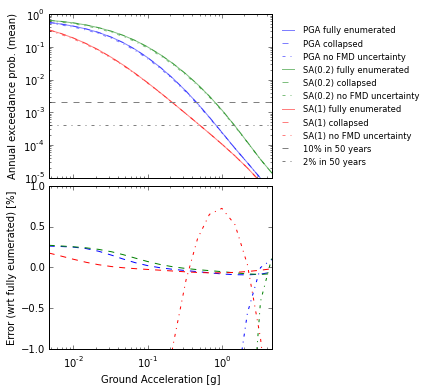

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(4,6), sharex=True)
fig.subplots_adjust(hspace=0.05)
imls = [item for item in df_results.columns if tb.is_numeric(item)]
imts = sorted(list(set(df_results['IMT'])))
linestyles = ['-', '--', '-.', ':']

for imt, color in zip(imts, axes[0]._get_lines.color_cycle):

    df_imt = df_results[df_results['IMT'] == imt]

    poes = np.array([[df_imt[df_imt['job'] == job][iml].values[0] for iml in imls] for job in jobs])
    poes_year = 1 - np.exp(np.log(1 - poes)/T_inv)
    
    for result, job, linestyle in zip(poes_year, jobs, linestyles):
        axes[0].loglog(imls, result, 
                       linestyle=linestyle, color=color, label=imt + ' ' + job, alpha=0.5)
    for result, job, linestyle in zip(poes_year[1:,:], jobs[1:], linestyles[1:]):
        axes[1].semilogx(imls, (result/poes_year[0,:] - 1)*100, 
                         linestyle=linestyle, color=color, label=imt + ' ' + job)

for prob, label, linestyle in zip(poes_inv, poe_labels, linestyles[1:]):
    axes[0].axhline(1 - np.exp(np.log(1 - prob)/T_inv), label=label, color='0.5', linestyle=linestyle)

axes[0].set_ylabel('Annual exceedance prob. (%s)' % quantile_string)
axes[1].set_ylabel('Error (wrt fully eumerated) [%]')
axes[1].set_xlabel('Ground Acceleration [g]')
axes[1].autoscale(True, 'x', 'tight')
axes[0].set_ylim((1e-5, 1))
axes[1].set_ylim((-1, 1))
axes[0].legend(loc='center left', frameon=False, bbox_to_anchor=(1, 0.5), fontsize='small')

file_name = '%s_%s_Zones_%s_%.2gyear.pdf' % (city,  quantile_string, 
                                             '_'.join([str(zone) for zone in nearest_zones]),
                                             T_inv)
fig.savefig(file_name, dpi=600, bbox_inches='tight', transparent=True)

In [35]:
df_imt

,ID,IMT,computation time,file,investigation time,job,quantile,0.0047,0.0068,0.01,...,0.15,0.22,0.33,0.47,0.68,1.0,1.5,2.2,3.3,4.7
2,177,SA(1),0:00:53,./guwahati_collapsed/export/hazard_curve-mean_...,0.083333,collapsed,mean,0.033129,0.024649,0.017202,...,0.000324,0.000159,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.123451e-07,2.338535e-07
5,178,SA(1),0:00:48,./guwahati_no_fmd_uncertainty/export/hazard_cu...,0.083333,no FMD uncertainty,mean,0.030460,0.022751,0.015952,...,0.000318,0.000158,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.072525e-07,2.289946e-07
8,179,SA(1),1:11:07,./guwahati_fully_enumerated/export/hazard_curv...,0.083333,fully enumerated,mean,0.033058,0.024610,0.017183,...,0.000324,0.000159,0.000074,0.000038,0.000019,0.000009,0.000004,0.000002,6.125591e-07,2.338946e-07
